In [1]:
pip install google_play_scraper

In [2]:
pip install stanza

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 881.2/881.2 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 358.9/358.9 kB 11.5 MB/s eta 0:00:00


In [3]:
import stanza
stanza.download('es')
nlp=stanza.Pipeline('es')

INFO:stanza:Downloading default packages for language: es (Spanish) ...


INFO:stanza:Finished downloading models and saved to /root/stanza_resources.
INFO:stanza:Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


INFO:stanza:Loading these models for language: es (Spanish):
| Processor    | Package         |
----------------------------------
| tokenize     | ancora          |
| mwt          | ancora          |
| pos          | ancora_charlm   |
| lemma        | ancora_nocharlm |
| constituency | combined_charlm |
| depparse     | ancora_charlm   |
| sentiment    | tass2020        |
| ner          | conll02         |

INFO:stanza:Using device: cuda
INFO:stanza:Loading: tokenize
INFO:stanza:Loading: mwt
INFO:stanza:Loading: pos
INFO:stanza:Loading: lemma
INFO:stanza:Loading: constituency
INFO:stanza:Loading: depparse
INFO:stanza:Loading: sentiment
INFO:stanza:Loading: ner
INFO:stanza:Done loading processors!


In [4]:
from google_play_scraper import app, Sort, reviews_all
import numpy as np
import pandas as pd
import re
import nltk
import numpy
import matplotlib.pyplot as plt
from wordcloud import WordCloud


In [5]:
from nltk.stem import SnowballStemmer
spanish_stemmer = SnowballStemmer('spanish')

In [6]:
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

In [7]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

True

In [8]:
aplicaciones={'Cookpad':'com.mufumbo.android.recipe.search',
              'MyFitnessPal':'com.myfitnesspal.android',
              #'Yummly':'com.yummly.android',
              #'Supercook ':'com.supercook.app',
              #'Eat This Much':'com.eatthismuch',
              #'Tasty':'com.buzzfeed.tasty',
              #'SideChef: Recipes & Meal Plans':'com.sidechef.sidechef',
              'MyrealFood: Recetas y dietas':'es.myrealfood.myrealfood',
              'ekilu - Recetas saludables':'es.nooddle',
              'Samsung Food':'com.foodient.whisk',
              'My Recipe Box : Recette Tek':'fr.recettetek',
              'Recipe Keeper':'com.tudorspan.recipekeeper',
              'Plan Meals - Meal Planner':'com.oneabsolute.mealplanner'
              #'Kitchen Stories: Recipes':'com.ajnsnewmedia.kitchenstories'
              }

In [9]:
g_reviews=[]
for i in aplicaciones:
  g = reviews_all(
        aplicaciones[i],
        sleep_milliseconds=0, # defaults to 0
        lang='es', # defaults to 'en'
        country='co', # defaults to 'us'
        sort=Sort.NEWEST, # defaults to Sort.MOST_RELEVANT
    )
  g_reviews.extend(g)


In [10]:
df1 = pd.DataFrame(g_reviews)

df1.drop(columns={'userImage', 'reviewCreatedVersion'},inplace = True)
df1.rename(columns= {'score': 'rating','userName': 'user_name', 'reviewId': 'review_id', 'content': 'review_description', 'at': 'review_date', 'replyContent': 'developer_response', 'repliedAt': 'developer_response_date', 'thumbsUpCount': 'thumbs_up'},inplace = True)
#g_df2.insert(loc=0, column='source', value='Google Play')
#g_df2.insert(loc=3, column='review_title', value=None)
result = df1

In [11]:
result=result[(result['rating']>=4)&(result['review_date'].dt.year>2020)][['review_description']]

In [12]:
datos=result.copy()
datos.columns=['Aplicacion']

In [13]:
datos=datos[['Aplicacion']]

In [14]:
def clean(x):
  x=x.lower()
  x = re.sub(r"https?\://\S+",' ', x)
  regex = '[\!\"\#\$\%\&\\(\)\*\+\,\-\.\/\:\;\<\=\>\?\@\[\\\]\^_\`\{\|\}\~]'
  x=re.sub(regex,' ',x)
  x = re.sub(r'\<a href', ' ', x)
  x = re.sub(r'&amp;', 'and', x)
  x = re.sub(r'<br />', ' ', x)
  x = re.sub(r'[_"\-;%()|+&=*%.,!?:#$@\[\]/]', ' ', x)
  x = re.sub('\d','', x)
  x = re.sub(r"can\'t", "cannot", x)
  x = re.sub(r"it\'s", "it is", x)
  return x

In [15]:
datos['Aplicacion_Clean']=datos['Aplicacion'].apply(lambda x: clean(str(x)))

In [16]:
stopw=stopwords.words("spanish")+['Si','si','le','para','app','solo','bien','él',
                                  'poner','hacer','dar','dejar','ahora','aplicación',
                                  'aplicacion','ir','decir','error','dar','el',
                                  'poder','buen','poner','abrir','que','yo','vez',
                                  'tener','querer','hacer','Ir','cosa','cada','i',
                                  'salir','ver','q','ser','asi','además','usar']+stopwords.words('english')

In [17]:
remove=lambda x: [[word for word in word_tokenize(sentence) if word not in stopw ]for sentence in sent_tokenize(x)]

In [18]:
datos['Aplicacion_Clean']=datos['Aplicacion_Clean'].apply(remove)

In [19]:
def combinar(x):
  try:
    return ' '.join(x[0])
  except:
    return np.nan

In [20]:
datos['Aplicacion_Clean']=datos['Aplicacion_Clean'].apply(lambda x: combinar(x))

In [21]:
datos.head()

,Aplicacion,Aplicacion_Clean
0,Tiene muchas resetas ricas 👍,muchas resetas ricas 👍
1,Grandes e enseñanzas,grandes enseñanzas
2,Muy buena aplicación,buena
3,Hola!! Las recetas de Cookpad son fáciles de h...,hola recetas cookpad fáciles medidas exactas b...
4,La verdad que tiene unas recetas muy buenas y ...,verdad unas recetas buenas excelentes explicac...


In [22]:
datos['Aplicacion_Clean']=datos['Aplicacion_Clean'].astype(str)

In [23]:
#datos['Aplicacion_Clean']=datos['Aplicacion_Clean'].apply(lambda x: " ".join(spanish_stemmer.stem(i) for i in word_tokenize(x)))
datos['Aplicacion_Clean']=datos['Aplicacion_Clean'].apply(lambda x:[[j.lemma for j in i.words] for i in nlp(x).sentences])#lematizador
datos['Aplicacion_Clean']=datos['Aplicacion_Clean'].apply(lambda x: combinar(x))

In [24]:
datos['Aplicacion_Clean']=datos['Aplicacion_Clean'].astype(str)

In [25]:
datos['Aplicacion_Clean']=datos['Aplicacion_Clean'].apply(remove)#remover stopwords que quedan luego de lematizar

In [26]:
datos['Aplicacion_Clean']=datos['Aplicacion_Clean'].apply(lambda x: combinar(x))

In [27]:
datos['Aplicacion_Clean']=datos['Aplicacion_Clean'].astype(str)

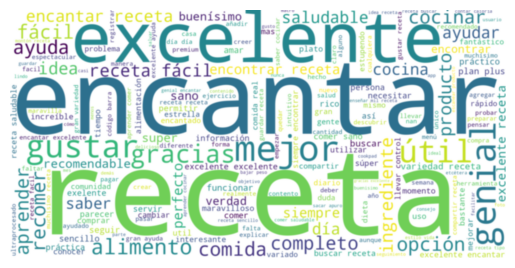

In [28]:
cloud=WordCloud(width=2000,height=1000,background_color='white').generate(" ".join(datos['Aplicacion_Clean']))
plt.imshow(cloud,interpolation='bicubic')
plt.axis('off')
plt.show()

## Identificación de tópicos

In [29]:
import gensim
from gensim.utils import simple_preprocess
import gensim.corpora as corpora
from pprint import pprint
import string

In [30]:
datos['model']=datos['Aplicacion_Clean'].apply(lambda x: word_tokenize(x))

In [31]:
p_lda=datos['model'].values.tolist()

In [32]:
idword=corpora.Dictionary(p_lda)

In [33]:
corpus=[idword.doc2bow(text)for text in p_lda]

In [34]:
lda_model=gensim.models.LdaMulticore(corpus=corpus,id2word=idword,num_topics=10,passes=500)#num topics controla los temas, passes el numero de entrenamientos para mejorar la relacion tema palabras

In [35]:
pprint(lda_model.print_topics())# se identifican temas de los comentarios en general

[(0,
  '0.120*"receta" + 0.119*"fácil" + 0.032*"rico" + 0.026*"buenísimo" + '
  '0.024*"super" + 0.024*"sencillo" + 0.022*"plus" + 0.017*"rápido" + '
  '0.016*"plan" + 0.016*"facil"'),
 (1,
  '0.045*"completo" + 0.036*"caloría" + 0.036*"llevar" + 0.031*"recomendable" '
  '+ 0.022*"control" + 0.020*"peso" + 0.020*"controlar" + 0.018*"👍" + '
  '0.017*"dieta" + 0.015*"versión"'),
 (2,
  '0.156*"útil" + 0.078*"día" + 0.017*"estilo" + 0.017*"mejor" + '
  '0.016*"problema" + 0.014*"duda" + 0.014*"momento" + 0.013*"base" + '
  '0.012*"recomendado" + 0.011*"totalmente"'),
 (3,
  '0.059*"mejor" + 0.048*"comer" + 0.038*"saludable" + 0.038*"alimento" + '
  '0.036*"producto" + 0.027*"comida" + 0.027*"sano" + 0.022*"saber" + '
  '0.014*"comprar" + 0.012*"alimentación"'),
 (4,
  '0.064*"perfecto" + 0.061*"bastante" + 0.056*"funcionar" + 0.055*"exelente" '
  '+ 0.038*"maravilloso" + 0.023*"espectacular" + 0.021*"️" + 0.021*"😊" + '
  '0.021*"lista" + 0.017*"buenisimo"'),
 (5,
  '0.438*"excelente" + 0.